# Information retrieval

<img src="../images/se_www.gif" alt="ml" style="width: 600px;"/>

In [1]:
# Global imports and settings
from preamble import *
%matplotlib inline
plt.rcParams['figure.dpi'] = 120 # Use 300 for PDF, 100 for slides
# InteractiveShell.ast_node_interactivity = "all"
HTML('''<style>html, body{overflow-y: visible !important} .CodeMirror{min-width:105% !important;} .rise-enabled .CodeMirror, .rise-enabled .output_subarea{font-size:140%; line-height:1.2; overflow: visible;} .output_subarea pre{width:110%}</style>''') # For slides

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

### Overview
<img src="../images/se_overview.png" alt="ml" style="width: 1000px;"/>

## Text Aquisition
* (Web) Crawlers
    * Follow any type of _link_ of _index_ to find documents
        * On the web, in documents, file systems,...
    * Coverage: must _efficiently_ find many web pages
    * Freshness: documents must be kept up-to-date
    * Topical or focused crawlers for vertical search (topic, domain, pagerank,…)
* Feeds (push vs. pull)
    * Real-time streams of documents (news, blogs,... )
    * Really Simple Syndication (RSS) standard
        * Fresh links in XML document

### Web Crawlers
* Finds and downloads web pages automatically
* Have to adapt continuously to evolving web
    * Web pages become increasingly complex
        * Javascript, media, reactive design,...
    * Adversarial environment
        * Unfair search engine 'optimization'

### Web crawlers: taxonomy
* Different crawlers have to adhere to different requirements
<img src="../images/se_crawler_types.png" alt="ml" style="width: 600px;"/>

#### Internet archive  (www.archive.org)
<img src="../images/se_internet_archive.png" alt="ml" style="width: 1000px;"/>

### Web Crawlers: Criteria
<img src="../images/se_crawler_criteria.png" alt="ml" style="width: 600px;"/>

### Web Crawlers: Architecture
* __Long-term scheduler__: Maintains queue of URLs to visit
* __Downloader__: Fetches new websites in parallel
    * Short-term queue to fulfill politeness constraints
* __Storage__: Extracts text, urls, metadata from website
<img src="../images/se_crawler_architecture.png" alt="ml" style="width: 600px;"/>

### Web Crawlers: Basic considerations
* HTTP requests take time
    * Fetch 100s of webpages in parallel
* Websites will block crawler if too aggressive
    * Politeness policies: don't hit same server to often
    * Short-term rescheduling to adhere to policies
* Distribute work over many machines
* Efficiency complications:
    * Remember which servers are slow for better scheduling
    * Site mirrors: don't index duplicate pages
* Adversarial websites:
    * Link farms to unfairly boost page ranking
    * Spider traps: generate infinite fake pages

### URL frontier: what to index next?
* URL frontier: list of all URL that you have found but not visited yet
<img src="../images/se_url_frontier.png" alt="ml" style="width: 600px;"/>

### URL frontier: what to index next?
* Keep all crawling threads busy but be polite
    * Implictly: don't affect website performance 
    * Explicitly: follow webmaster's wishes
        * Robots.txt, sitemaps
* Heuristic: time between successive requests >> host request latency
* Freshness: crawl pages that update frequently more often
    * e.g. news sites
    * balance with politeness 

#### Robots.txt
* Written by webmaster, tells crawlers what (not) to index
    * Specific sites/folders may be allowed or disallowed
* If not followed, an angry webmaster may block the crawler entirely
* [Further reading](https://www.contentkingapp.com/academy/robotstxt/)

<img src="../images/se_robots.png" alt="ml" style="width: 500px;"/>

#### Sitemap.xml
* Generated by webmaster, informs crawlers:
    * Which pages should be indexed (even if not linked)
    * When and how often pages are updated
* [Further reading](https://moz.com/blog/xml-sitemaps)

<img src="../images/se_sitemap.png" alt="ml" style="width: 500px;"/>

### Mercator Scheme
* High performance crawling
* Balance coverage, freshness, politeness    
<img src="../images/se_mercator.png" alt="ml" style="width: 500px;"/>

### Mercator Scheme
* Front queues: K queues, ordered from highest to lowest prioriity
    * Prioritizer assigns every new URL to specific queue
    * Heuristics to ensure freshness:
        * Refresh rate sampled from previous crawls
        * Application-specific (e.g., “crawl news sites more often”)
* Back queues: B queues, one per website host
    * Front queue selector chooses a front queue to pull a URL
        * Round robin, biased to high-priority queues
        * Ensures that back queues are never empty
* Back queue selector keeps sorted heap of all back queues
    * Sorted by when each host may/should be be contacted again
    * Ensures that hosts are not hit too frequently, keeps threads busy
* Crawler thread pulls URL from root of sorted heap

### Freshness
* HTTP HEAD requests allows query to check for updates without downloading page itself
<img src="../images/se_head.png" alt="ml" style="width: 500px;"/>

### Freshness
* Web page updates tend to follow a Poisson distribution
* The older a page gets, the more it 'costs' not to crawl it again
* Evaluation metrics of freshness policy:
    * Age: t(visit) - t(modified)
    * Number of changes, average change interval

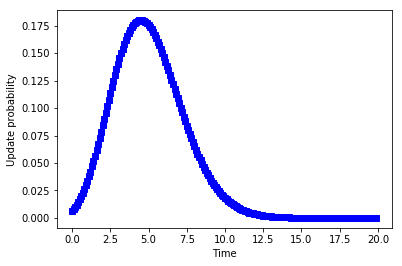

In [3]:
from scipy.misc import factorial

t = np.arange(0, 20, 0.1)
d = np.exp(-5)*np.power(5, t)/factorial(t)

plt.plot(t, d, 'bs')
plt.xlabel('Time')
plt.ylabel('Update probability')
plt.show()

### Basic crawling process
<img src="../images/se_crawl_process.png" alt="ml" style="width: 700px;"/>

### Basic crawling process
* Fetch URL from frontier (e,g, Mercator scheme)
* Download and parse webpage, extract links
* Check if content already seen, if not, add to document index
    * Checksum, cyclic redundancy check, Bloom filter,...
    * Near-duplicate detection (shingling)
* For each extracted URL:
    * Check if it passes filters (e.g. only crawl .edu pages)
    * Check if already in frontier (eliminate duplicates)
    * Add to URL frontier or URL store

#### Distributed crawling
* Use hash function to assign URLs to crawler hosts
* Broadcast URL list _from_ every host, _to_ every host
<img src="../images/se_crawl_process2.png" alt="ml" style="width: 700px;"/>

### Deep web
<img src="../images/se_darkweb.png" alt="ml" style="width: 700px;"/>

### Open-source crawlers
* [NUTCH (Java)](http://nutch.apache.org/)
    * part of the Lucene search engine
    * supports large-scale crawling (Hadoop, Spark)
* [WIRE (C++)](http://www.cwr.cl/projects/WIRE/)
    * several policies for scheduling page downloads
    * generating reports/statistics on downloaded pages
* [Beautiful Soup (Python)](https://www.crummy.com/software/BeautifulSoup/bs4/doc/)
    * `pip install BeautifulSoup4`
    * powerful HTML parser
    * relies on other libraries for downloading and storing
* [Scrapy (Python)](https://scrapy.org/)
    * `pip install scrapy`
    * to write an entire (asynchronous) crawler
    * more powerful, keep politeness in mind!

#### Installation

```python
    pip install BeautifulSoup4
    pip install requests
    pip install scrapy
```

### Beautiful Soup example
* Use `requests` to do an HTML request
* Use BeautifulSoup to convert the HTML content into a Python object
* Query the BeautifulSoup object for the information you are interested in
    * This is he actual `scraping` for relevant information
    * You may need to look at the HTML to see where to find the information
* This returns the weather at TU/e right now:
    
``` python    
    page = requests.get("https://darksky.net/forecast/51.4466,5.4916/ca12/en")
    soup = BeautifulSoup(page.content, 'html.parser')
    summary = soup.find_all('span', class_='summary')[0].get_text()
    forecast = soup.find_all('span', class_='next')[0].get_text()
```

In [4]:
import requests
import html
from bs4 import BeautifulSoup

page = requests.get("https://darksky.net/forecast/51.4466,5.4916/ca12/en")
soup = BeautifulSoup(page.content, 'html.parser')
summary = soup.find_all('span', class_='summary')[0].get_text()
forecast = soup.find_all('span', class_='next')[0].get_text()
print(html.unescape(summary))
print(html.unescape(forecast))

6˚ Drizzle and Breezy.

          
          Rain and breezy until this evening.
        


* Get all URLs on the page
    * You'll still need to resolve relative links

``` python
    [x.get('href') for x in soup.find_all('a') if x.get('href') is not None]
```

In [5]:
[x.get('href') for x in soup.find_all('a') if x.get('href') is not None]

['/',
 '/app',
 '/maps',
 '/dev',
 '/help/website',
 '/about',
 'https://twitter.com/darkskyapp',
 '/forecast/51.4466,5.4916/ca12/en',
 '/details/51.4466,5.4916/2019-3-13/ca12/en',
 '/details/51.4466,5.4916/2019-3-14/ca12/en',
 '/details/51.4466,5.4916/2019-3-15/ca12/en',
 '/details/51.4466,5.4916/2019-3-16/ca12/en',
 '/details/51.4466,5.4916/2019-3-17/ca12/en',
 '/details/51.4466,5.4916/2019-3-18/ca12/en',
 '/details/51.4466,5.4916/2019-3-19/ca12/en',
 '/details/51.4466,5.4916/2019-3-20/ca12/en',
 '/dev',
 '/app',
 '/sports',
 '/widgets',
 'http://github.com/darkskyapp',
 '/tos',
 'https://blog.darksky.net/',
 '/help',
 '/contact',
 '/about',
 '/privacy',
 '/jobs']

#### Scrapy example
* A simple spider for quotes
* Beware: the runner is an asynchronous process, you need to start/stop it correctly (see code)

``` python
    import scrapy
    import scrapy.crawler as crawler

    class QuotesSpider(scrapy.Spider):
        name = "quotes"
        start_urls = ['http://quotes.toscrape.com/tag/humor/']

        def parse(self, response):
            for quote in response.css('div.quote'):
                print(quote.css('span.text::text').extract_first())
            
    runner = crawler.CrawlerRunner()
    deferred = runner.crawl(QuotesSpider)
```

Example run:

In [6]:
import scrapy
import scrapy.crawler as crawler
from multiprocessing import Process, Queue
from twisted.internet import reactor

# the spider itself
class QuotesSpider(scrapy.Spider):
    name = "quotes"
    start_urls = ['http://quotes.toscrape.com/tag/humor/']

    def parse(self, response):
        for quote in response.css('div.quote'):
            print(quote.css('span.text::text').extract_first())


# the wrapper to handle asynchronous runs
def run_spider(spider):
    def f(q):
        try:
            runner = crawler.CrawlerRunner()
            deferred = runner.crawl(spider)
            deferred.addBoth(lambda _: reactor.stop())
            reactor.run()
            q.put(None)
        except Exception as e:
            q.put(e)

    q = Queue()
    p = Process(target=f, args=(q,))
    p.start()
    result = q.get()
    p.join()

    if result is not None:
        raise result

In [7]:
run_spider(QuotesSpider)

“The person, be it gentleman or lady, who has not pleasure in a good novel, must be intolerably stupid.”
“A day without sunshine is like, you know, night.”
“Anyone who thinks sitting in church can make you a Christian must also think that sitting in a garage can make you a car.”
“Beauty is in the eye of the beholder and it may be necessary from time to time to give a stupid or misinformed beholder a black eye.”
“All you need is love. But a little chocolate now and then doesn't hurt.”
“Remember, we're madly in love, so it's all right to kiss me anytime you feel like it.”
“Some people never go crazy. What truly horrible lives they must lead.”
“The trouble with having an open mind, of course, is that people will insist on coming along and trying to put things in it.”
“Think left and think right and think low and think high. Oh, the thinks you can think up if only you try!”
“The reason I talk to myself is because I’m the only one whose answers I accept.”


* See the [Scrapy documentation](https://docs.scrapy.org) for many more examples
* Don't forget to be polite, also known as _trottling_
* You can set options in a `settings.py` file, e.g.

``` python
    ROBOTSTXT_OBEY=True
    DOWNLOAD_DELAY = 1.5
    AUTOTHROTTLE_ENABLED = True
    AUTOTHROTTLE_START_DELAY = 2
    AUTOTHROTTLE_TARGET_CONCURRENCY = 6
```

## Text Selection and Transformation
* Use a parser to identify structure of HTML, XML 
* When building a search index, only index useful words
    * Stop word removal (“and”, “or”, “the”, “in”)
    * Stemming (“computer”, “computers”, “computing”, “compute”)
* Remove noise: ads, clickbait, non-content (hard)
* Link analysis
    * Identify popularity and community information (e.g. Pagerank)
* Information extraction
    * Named entity recognition to identify people, places, dates,...
    * e.g. Google Knowledge Graph
* Classification
    * Extract topics, reading levels, sentiment, genre,...

## Document Data storage
* Page content, meta-data (e.g. creation date), links,...
* Requires fast access (indexes) for the search engine
    * Ranking, snippet generation, ...
* Usually a distributed system
    * Distributed search engine (e.g. ElasticSearch)
    * Semi-structured storage (e.g. BigTable, HBase)
    * Distributed computing (e.g. MapReduce, Spark)
    * Distributed analysis (e.g. MLlib)

#### Hadoop/MapReduce ecosystem
<img src="../images/se_hadoop.png" alt="ml" style="width: 700px;"/>

#### Spark ecosystem
* [Online course](https://www.edx.org/course/distributed-machine-learning-apache-uc-berkeleyx-cs120x)
* [(Free) Community Edition](https://databricks.com/try-databricks)
<img src="../images/se_spark.png" alt="ml" style="width: 700px;"/>